# DPF Resampling Methods Comparison: Stochastic Volatility Model

This notebook compares three differentiable particle filter resampling methods on a **nonlinear, non-Gaussian** stochastic volatility model:

1. **DPF-Soft**: Gumbel-Softmax with mixture resampling
2. **DPF-OT**: Optimal Transport (Sinkhorn) resampling
3. **DPF-RNN**: RNN-learned resampling strategy

## Model: 1-D Stochastic Volatility

$$
\begin{align}
X_t &= \alpha X_{t-1} + \sigma V_t, \quad V_t \sim \mathcal{N}(0, 1) \\
Y_t &= \beta \exp(0.5 X_t) W_t, \quad W_t \sim \mathcal{N}(0, 1)
\end{align}
$$

This is a challenging benchmark because:
- **Nonlinear observations**: $\exp(0.5 X_t)$ creates highly skewed likelihood
- **Non-Gaussian**: Observations have multiplicative noise
- **State-dependent noise**: Volatility depends exponentially on hidden state

In [11]:
"""
Comprehensive Comparison of DPF Resampling Methods on Stochastic Volatility Model

This notebook evaluates three differentiable particle filter resampling strategies
on a challenging nonlinear, non-Gaussian state-space model.
"""

import numpy as np
import tensorflow as tf
import time
from scipy import stats
import matplotlib.pyplot as plt
import json
import os
import sys

# Add parent directory to path
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.insert(0, os.path.join(parent_dir, 'models'))
sys.path.insert(0, os.path.join(parent_dir, 'simulator'))

# Import filter implementations
from DPF_soft_resampling import DifferentiableParticleFilter
from DPF_OT_resampling import DPF_OT
from DPF_RNN_resampling import DifferentiableParticleFilterRNN

# Import stochastic volatility simulator
from simulator_sto_volatility_model import simulate_sv_1d

print("✓ All modules imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All modules imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3


## 1. Data Generation

Generate synthetic data from the stochastic volatility model.

In [12]:
# Generate stochastic volatility data
T = 100  # Number of time steps
alpha = 0.95  # AR(1) coefficient (high persistence)
sigma = 0.2  # State noise std
beta = 0.6  # Observation scale
seed = 42

# Simulate data
sv_results = simulate_sv_1d(
    n=T,
    alpha=alpha,
    sigma=sigma,
    beta=beta,
    seed=seed
)

# Extract states and observations
X_true = sv_results.X  # (T,)
Y_obs = sv_results.Y   # (T,)

# Reshape for filtering (add dimension)
X_true_3d = X_true.reshape(1, T, 1).astype(np.float32)  # (1, T, 1)
Y_obs_3d = Y_obs.reshape(1, T, 1).astype(np.float32)    # (1, T, 1)

print(f"Generated {T} time steps")
print(f"State X range: [{X_true.min():.3f}, {X_true.max():.3f}]")
print(f"Observation Y range: [{Y_obs.min():.3f}, {Y_obs.max():.3f}]")
print(f"\nModel parameters:")
print(f"  α (persistence): {alpha}")
print(f"  σ (state noise): {sigma}")
print(f"  β (obs scale):   {beta}")

Generated 100 time steps
State X range: [-1.116, 0.773]
Observation Y range: [-1.514, 2.002]

Model parameters:
  α (persistence): 0.95
  σ (state noise): 0.2
  β (obs scale):   0.6


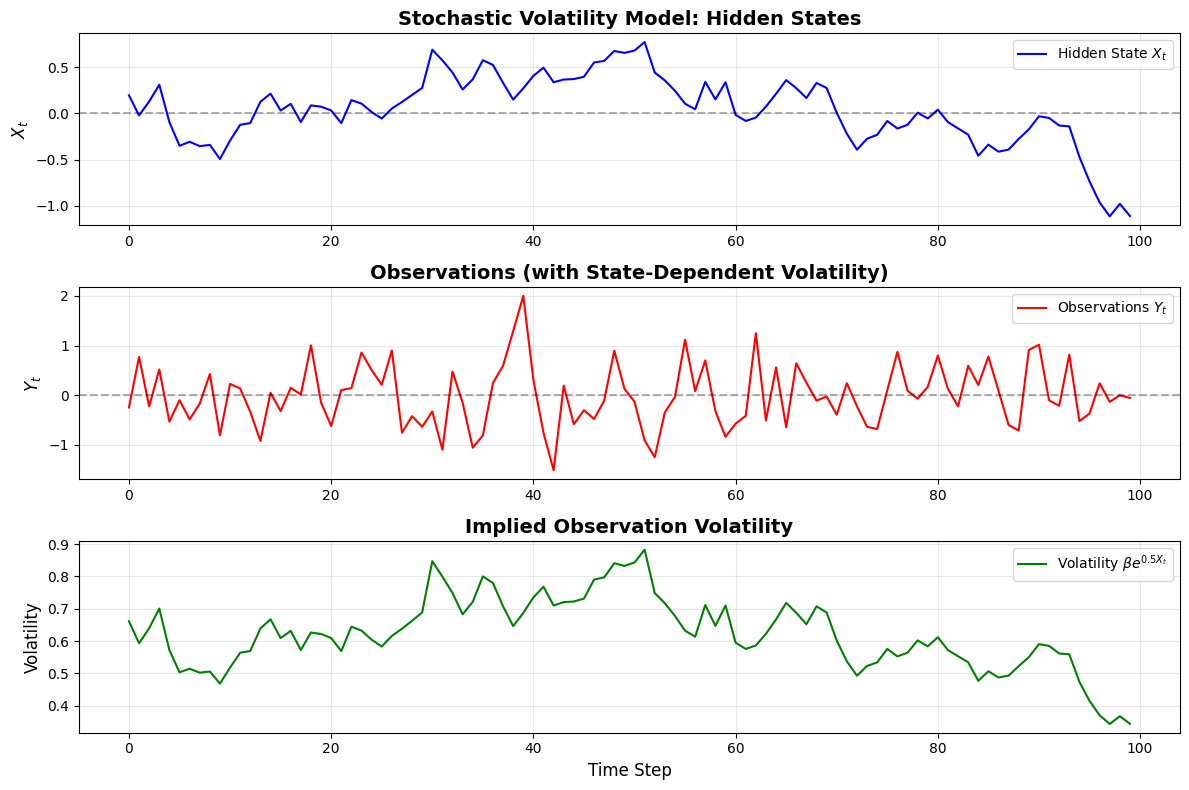


Data characteristics:
  Mean state: 0.037 ± 0.377
  Mean observation: -0.013 ± 0.618
  Mean volatility: 0.622 ± 0.111


In [8]:
# Visualize the data
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot hidden states
axes[0].plot(X_true, 'b-', linewidth=1.5, label='Hidden State $X_t$')
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].set_ylabel('$X_t$', fontsize=12)
axes[0].set_title('Stochastic Volatility Model: Hidden States', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot observations
axes[1].plot(Y_obs, 'r-', linewidth=1.5, label='Observations $Y_t$')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_ylabel('$Y_t$', fontsize=12)
axes[1].set_title('Observations (with State-Dependent Volatility)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot implied volatility
volatility = beta * np.exp(0.5 * X_true)
axes[2].plot(volatility, 'g-', linewidth=1.5, label=r'Volatility $\beta e^{0.5 X_t}$')
axes[2].set_xlabel('Time Step', fontsize=12)
axes[2].set_ylabel('Volatility', fontsize=12)
axes[2].set_title('Implied Observation Volatility', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData characteristics:")
print(f"  Mean state: {X_true.mean():.3f} ± {X_true.std():.3f}")
print(f"  Mean observation: {Y_obs.mean():.3f} ± {Y_obs.std():.3f}")
print(f"  Mean volatility: {volatility.mean():.3f} ± {volatility.std():.3f}")

## 2. Define Model Functions

Define the transition and observation models for each filter type.

In [9]:
# ========================================================================
# Model Functions for DPF-Soft and DPF-RNN (batched, TensorFlow)
# ========================================================================

def sv_transition_batched(x_prev, params):
    """Stochastic volatility transition model (batched).

    Implements: X_t = alpha * X_{t-1} + sigma * V_t,  V_t ~ N(0, 1)

    Args:
        x_prev (tf.Tensor): Previous particles of shape (B, N, D).
        params (dict): Parameters containing 'alpha' and 'sigma'.

    Returns:
        tf.Tensor: New particles of shape (B, N, D).
    """
    alpha_val = params.get("alpha", 0.95)
    sigma_val = params.get("sigma", 0.2)
    
    alpha_val = tf.convert_to_tensor(alpha_val, dtype=tf.float32)
    sigma_val = tf.convert_to_tensor(sigma_val, dtype=tf.float32)
    
    # Reshape to broadcast
    alpha_val = tf.reshape(alpha_val, (1, 1, 1))
    sigma_val = tf.reshape(sigma_val, (1, 1, 1))
    
    # Sample noise
    eps = tf.random.normal(tf.shape(x_prev), dtype=tf.float32)
    
    # AR(1) transition
    x_new = alpha_val * x_prev + sigma_val * eps
    
    return x_new


def sv_log_likelihood_batched(x, y, params):
    """Stochastic volatility observation model (batched).

    Implements: Y_t = beta * exp(0.5 * X_t) * W_t,  W_t ~ N(0, 1)
    This gives: p(Y_t | X_t) = N(0, beta^2 * exp(X_t))

    Args:
        x (tf.Tensor): Particles of shape (B, N, D).
        y (tf.Tensor): Observations of shape (B, D).
        params (dict): Parameters containing 'beta'.

    Returns:
        tf.Tensor: Log-likelihood for each particle of shape (B, N).
    """
    beta_val = params.get("beta", 0.6)
    beta_val = tf.convert_to_tensor(beta_val, dtype=tf.float32)
    
    # Expand y to match particles: (B, 1, D) -> (B, N, D)
    y = tf.expand_dims(y, axis=1)
    y = tf.broadcast_to(y, tf.shape(x))
    
    # Observation variance: beta^2 * exp(X_t)
    var = (beta_val ** 2) * tf.exp(x)  # (B, N, D)
    
    # Log-likelihood: log N(y; 0, var)
    log_norm_const = -0.5 * tf.math.log(2.0 * np.pi * var)
    log_lik = log_norm_const - 0.5 * (y ** 2) / var  # (B, N, D)
    
    # Sum over dimensions and squeeze
    log_lik = tf.reduce_sum(log_lik, axis=-1)  # (B, N)
    
    return log_lik


# ========================================================================
# Model Functions for DPF-OT (unbatched, TensorFlow)
# ========================================================================

def sv_transition_ot(particles, t):
    """Stochastic volatility transition for DPF-OT (unbatched).

    Args:
        particles (tf.Tensor): Particles at time t-1 of shape (N, D).
        t (int): Time index (not used, but required by interface).

    Returns:
        tf.Tensor: New particles at time t of shape (N, D).
    """
    alpha_val = 0.95
    sigma_val = 0.2
    
    noise = tf.random.normal(tf.shape(particles), stddev=sigma_val)
    return alpha_val * particles + noise


def sv_obs_loglik_ot(particles, y_t, t):
    """Stochastic volatility observation log-likelihood for DPF-OT (unbatched).

    Args:
        particles (tf.Tensor): Particles of shape (N, D).
        y_t (np.ndarray or tf.Tensor): Observation at time t of shape (D,).
        t (int): Time index (not used).

    Returns:
        tf.Tensor: Log-likelihood for each particle of shape (N,).
    """
    beta_val = 0.6
    
    y_t = tf.convert_to_tensor(y_t, dtype=tf.float32)
    
    # Observation variance: beta^2 * exp(X_t)
    var = (beta_val ** 2) * tf.exp(particles)  # (N, D)
    
    # Log-likelihood
    log_norm_const = -0.5 * tf.math.log(2.0 * np.pi * var)
    log_lik = log_norm_const - 0.5 * (y_t[None, :] ** 2) / var  # (N, D)
    
    # Sum over dimensions
    log_lik = tf.reduce_sum(log_lik, axis=-1)  # (N,)
    
    return log_lik


print("✓ Model functions defined successfully!")

✓ Model functions defined successfully!


## 3. Initialize Particle Filters

Create instances of all three DPF resampling methods.

In [13]:
# Common parameters
N_PARTICLES = 100
STATE_DIM = 1

# Model parameters for filters
params = {
    'alpha': alpha,
    'sigma': sigma,
    'beta': beta
}

# Initial distribution (stationary for AR(1))
init_mean = np.zeros((STATE_DIM,), dtype=np.float32)
stationary_var = sigma**2 / (1 - alpha**2)
init_cov_chol = np.sqrt(stationary_var) * np.eye(STATE_DIM, dtype=np.float32)

print(f"Filter Configuration:")
print(f"  Number of particles: {N_PARTICLES}")
print(f"  State dimension: {STATE_DIM}")
print(f"  Initial mean: {init_mean}")
print(f"  Initial std: {init_cov_chol[0, 0]:.4f}")

# ========================================================================
# 1. DPF-Soft (Gumbel-Softmax Resampling)
# ========================================================================
dpf_soft = DifferentiableParticleFilter(
    n_particles=N_PARTICLES,
    state_dim=STATE_DIM,
    transition_fn=sv_transition_batched,
    log_likelihood_fn=sv_log_likelihood_batched,
    soft_alpha=0.1,  # Mixture parameter
    gumbel_temperature=0.5,  # Temperature for Gumbel-Softmax
    name='DPF_Soft_SV'
)

print("\n✓ DPF-Soft initialized")
print(f"  Soft alpha: {dpf_soft.soft_alpha}")
print(f"  Gumbel temperature: {dpf_soft.gumbel_temperature}")

# ========================================================================
# 2. DPF-OT (Optimal Transport Resampling)
# ========================================================================
dpf_ot = DPF_OT(
    N_particles=N_PARTICLES,
    state_dim=STATE_DIM,
    transition_fn=sv_transition_ot,
    obs_loglik_fn=sv_obs_loglik_ot,
    epsilon=0.1,  # Entropic regularization
    sinkhorn_iters=50,  # Max Sinkhorn iterations
    name='DPF_OT_SV'
)

print("\n✓ DPF-OT initialized")
print(f"  Epsilon: {dpf_ot.epsilon}")
print(f"  Max Sinkhorn iterations: {dpf_ot.sinkhorn_iters}")

# ========================================================================
# 3. DPF-RNN (RNN-Learned Resampling)
# ========================================================================
dpf_rnn = DifferentiableParticleFilterRNN(
    n_particles=N_PARTICLES,
    state_dim=STATE_DIM,
    transition_fn=sv_transition_batched,
    log_likelihood_fn=sv_log_likelihood_batched,
    rnn_type='lstm',
    rnn_hidden_dim=32,
    rnn_num_layers=1,
    name='DPF_RNN_SV'
)

print("\n✓ DPF-RNN initialized")
print(f"  RNN type: {dpf_rnn.rnn_type}")
print(f"  Hidden dim: {dpf_rnn.rnn_hidden_dim}")
print(f"  Number of layers: {dpf_rnn.rnn_num_layers}")

print("\n" + "="*60)
print("All filters initialized successfully!")
print("="*60)

Filter Configuration:
  Number of particles: 100
  State dimension: 1
  Initial mean: [0.]
  Initial std: 0.6405

✓ DPF-Soft initialized
  Soft alpha: 0.1
  Gumbel temperature: 0.5

✓ DPF-OT initialized
  Epsilon: 0.1
  Max Sinkhorn iterations: 50
✓ RNN initialized with small random weights (safe baseline)
  Initial behavior: Nearly uniform assignments (high entropy)
  Note: Training is still recommended for optimal performance

✓ DPF-RNN initialized
  RNN type: lstm
  Hidden dim: 32
  Number of layers: 1

All filters initialized successfully!


## 4. Run Filters and Collect Metrics

Run all three filters on the same data and collect comprehensive metrics.

In [19]:
def compute_ess(log_weights):
    """Compute Effective Sample Size from log weights.

    Args:
        log_weights (tf.Tensor): Log weights of particles.

    Returns:
        tf.Tensor: Effective Sample Size.
    """
    weights = tf.nn.softmax(log_weights, axis=-1)
    ess = 1.0 / tf.reduce_sum(weights ** 2, axis=-1)
    return ess


def compute_weight_entropy(log_weights):
    """Compute normalized entropy of weight distribution.

    Args:
        log_weights (tf.Tensor): Log weights of particles.

    Returns:
        tf.Tensor: Normalized entropy (0 to 1).
    """
    weights = tf.nn.softmax(log_weights, axis=-1)
    entropy = -tf.reduce_sum(weights * tf.math.log(weights + 1e-10), axis=-1)
    max_entropy = tf.math.log(tf.cast(tf.shape(weights)[-1], tf.float32))
    return entropy / max_entropy


def run_filter_with_metrics(filter_obj, x_true, y_obs, init_mean, init_cov_chol, params, filter_name):
    """Run a particle filter and collect comprehensive metrics.

    Args:
        filter_obj: Filter instance (DPF-Soft, DPF-OT, or DPF-RNN).
        x_true (np.ndarray): Ground truth states of shape (T,).
        y_obs (np.ndarray): Observations of shape (1, T, 1).
        init_mean (np.ndarray): Initial mean of shape (state_dim,).
        init_cov_chol (np.ndarray): Initial covariance Cholesky factor.
        params (dict): Model parameters.
        filter_name (str): Name of the filter ('DPF-Soft', 'DPF-OT', 'DPF-RNN').

    Returns:
        dict: Results containing rmse, runtime, diagnostics, and particle means.
    """
    print(f"\nRunning {filter_name}...")
    start_time = time.time()
    
    # Prepare data
    if filter_name == "DPF-OT":
        # DPF-OT expects list/array of observations, each (D,) shaped
        # Y_obs is (1, T, 1), squeeze to (T,) then reshape to list of (1,) arrays
        y_seq = [y_obs[0, t, :] for t in range(y_obs.shape[1])]  # List of T arrays, each (1,)
    else:
        # DPF-Soft and DPF-RNN use batched format (B, T, D)
        y_seq = y_obs  # (1, T, 1)
    
    # Run filter
    if filter_name == "DPF-OT":
        # DPF-OT uses run_filter() method
        particles_list, weights_list, diagnostics = filter_obj.run_filter(
            y_seq=y_seq,
            mean0=init_mean,
            cov0_chol=init_cov_chol,
            return_diagnostics=True
        )
        # Convert lists to tensors - particles_list is list of (N, D)
        particles = tf.stack(particles_list, axis=0)  # (T, N, D)
        weights = weights_list  # Keep as list for now
        
    else:
        # DPF-Soft and DPF-RNN use filter() method with 'observations'
        if filter_name == "DPF-RNN":
            # DPF-RNN returns 4 values (or 5 with return_ess=True)
            particles, log_weights, assignment_matrices, ess_stats = filter_obj.filter(
                observations=y_seq,
                init_mean=init_mean,
                init_cov_chol=init_cov_chol,
                params=params,
                return_ess=True
            )
            diagnostics = ess_stats
        else:
            # DPF-Soft returns 3 values
            particles, log_weights, diagnostics = filter_obj.filter(
                observations=y_seq,
                init_mean=init_mean,
                init_cov_chol=init_cov_chol,
                params=params,
                return_diagnostics=True
            )
    
    elapsed = time.time() - start_time
    
    # Compute metrics
    results = {
        'filter_name': filter_name,
        'runtime': elapsed,
        'diagnostics': diagnostics
    }
    
    # Compute particle mean estimates
    if filter_name == "DPF-OT":
        # For OT, particles is (T, N, D), weights is list of (N,)
        particle_means = []
        for t in range(len(weights)):
            p_t = particles[t]  # (N, D)
            w_t = weights[t]  # (N,)
            w_normalized = tf.nn.softmax(w_t)
            mean_t = tf.reduce_sum(p_t * w_normalized[:, None], axis=0)
            particle_means.append(mean_t.numpy())
        particle_means = np.array(particle_means)  # (T, D)
    else:
        # For Soft and RNN, particles is (B, T+1, N, D), log_weights is (B, T+1, N)
        # We want estimates at times 1..T (excluding initial time 0)
        particles_filtered = particles[:, 1:, :, :]  # (B, T, N, D)
        log_weights_filtered = log_weights[:, 1:, :]  # (B, T, N)
        weights = tf.nn.softmax(log_weights_filtered, axis=2)  # (B, T, N)
        particle_means = tf.reduce_sum(
            particles_filtered * weights[:, :, :, None],
            axis=2
        ).numpy()  # (B, T, D)
        particle_means = particle_means[0]  # (T, D)
    
    # Compute RMSE
    x_true_seq = x_true.reshape(T, STATE_DIM)  # (T, D)
    squared_errors = (particle_means - x_true_seq) ** 2
    rmse = np.sqrt(np.mean(squared_errors))
    results['rmse'] = rmse
    results['particle_means'] = particle_means
    
    # Compute ESS and entropy metrics from diagnostics
    if filter_name == "DPF-Soft":
        # DPF-Soft returns aggregated diagnostics with _mean suffix
        if 'ess_before_mean' in diagnostics:
            val = diagnostics['ess_before_mean']
            results['avg_ess_before'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'ess_after_mean' in diagnostics:
            val = diagnostics['ess_after_mean']
            results['avg_ess_after'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'entropy_before_mean' in diagnostics:
            val = diagnostics['entropy_before_mean']
            results['avg_entropy_before'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'entropy_after_mean' in diagnostics:
            val = diagnostics['entropy_after_mean']
            results['avg_entropy_after'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'assignment_entropy_mean' in diagnostics:
            val = diagnostics['assignment_entropy_mean']
            results['avg_assignment_entropy'] = float(val.numpy() if hasattr(val, 'numpy') else val)
            
    elif filter_name == "DPF-OT":
        # DPF-OT also returns aggregated diagnostics with _mean suffix (like DPF-Soft)
        if 'ess_before_mean' in diagnostics:
            val = diagnostics['ess_before_mean']
            results['avg_ess_before'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'ess_after_mean' in diagnostics:
            val = diagnostics['ess_after_mean']
            results['avg_ess_after'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'entropy_before_mean' in diagnostics:
            val = diagnostics['entropy_before_mean']
            results['avg_entropy_before'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        if 'entropy_after_mean' in diagnostics:
            val = diagnostics['entropy_after_mean']
            results['avg_entropy_after'] = float(val.numpy() if hasattr(val, 'numpy') else val)
        # Sinkhorn-specific metrics
        if 'sinkhorn_iterations_mean' in diagnostics:
            val = diagnostics['sinkhorn_iterations_mean']
            results['avg_sinkhorn_iters'] = float(val.numpy() if hasattr(val, 'numpy') else val)
            
    elif filter_name == "DPF-RNN":
        # DPF-RNN returns ESS statistics in ess_stats dict
        ess_before = diagnostics.get('ess_before_resampling', [])
        ess_after = diagnostics.get('ess_after_resampling', [])
        entropy_before = diagnostics.get('entropy_before_resampling', [])
        entropy_after = diagnostics.get('entropy_after_resampling', [])
        
        if len(ess_before) > 0:
            results['avg_ess_before'] = np.mean([e.numpy() if hasattr(e, 'numpy') else e for e in ess_before])
        if len(ess_after) > 0:
            results['avg_ess_after'] = np.mean([e.numpy() if hasattr(e, 'numpy') else e for e in ess_after])
        if len(entropy_before) > 0:
            results['avg_entropy_before'] = np.mean([e.numpy() if hasattr(e, 'numpy') else e for e in entropy_before])
        if len(entropy_after) > 0:
            results['avg_entropy_after'] = np.mean([e.numpy() if hasattr(e, 'numpy') else e for e in entropy_after])
    
    print(f"  ✓ Completed in {elapsed:.3f}s")
    print(f"  RMSE: {rmse:.4f}")
    
    return results


# Run all three filters
results_soft = run_filter_with_metrics(
    dpf_soft, X_true, Y_obs_3d, init_mean, init_cov_chol, params, "DPF-Soft"
)

results_ot = run_filter_with_metrics(
    dpf_ot, X_true, Y_obs_3d, init_mean, init_cov_chol, params, "DPF-OT"
)

results_rnn = run_filter_with_metrics(
    dpf_rnn, X_true, Y_obs_3d, init_mean, init_cov_chol, params, "DPF-RNN"
)

print("\n" + "="*60)
print("All filters completed!")
print("="*60)


Running DPF-Soft...
  ✓ Completed in 0.762s
  RMSE: 0.3586

Running DPF-OT...
  ✓ Completed in 0.762s
  RMSE: 0.3586

Running DPF-OT...
  ✓ Completed in 626.717s
  RMSE: 0.3131

Running DPF-RNN...
  ✓ Completed in 841.977s
  RMSE: 0.3496

All filters completed!


## 5. Performance Comparison

Compare the three methods across key metrics.

In [20]:
# Create comparison summary
methods = ['DPF-Soft', 'DPF-OT', 'DPF-RNN']
results_list = [results_soft, results_ot, results_rnn]

print("\n" + "="*80)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*80)

# Comparison table
print("\n{:<15} {:<12} {:<15} {:<15}".format("Method", "RMSE", "Runtime (s)", "Speedup"))
print("-" * 80)

best_runtime = min(r['runtime'] for r in results_list)
for result in results_list:
    speedup = result['runtime'] / best_runtime
    print("{:<15} {:<12.4f} {:<15.3f} {:<15.2f}x".format(
        result['filter_name'],
        result['rmse'],
        result['runtime'],
        speedup
    ))

# Find winners
best_rmse = min(r['rmse'] for r in results_list)
best_rmse_method = [r['filter_name'] for r in results_list if r['rmse'] == best_rmse][0]
fastest_method = [r['filter_name'] for r in results_list if r['runtime'] == best_runtime][0]

print("\n" + "-" * 80)
print(f"🏆 Best Accuracy: {best_rmse_method} (RMSE = {best_rmse:.4f})")
print(f"⚡ Fastest: {fastest_method} (Time = {best_runtime:.3f}s)")

# Additional metrics if available
print("\n" + "="*80)
print("ADDITIONAL METRICS")
print("="*80)

for result in results_list:
    print(f"\n{result['filter_name']}:")
    if 'avg_ess_before' in result:
        print(f"  Avg ESS (before resampling): {result['avg_ess_before']:.2f} / {N_PARTICLES}")
    if 'avg_ess_after' in result:
        print(f"  Avg ESS (after resampling):  {result['avg_ess_after']:.2f} / {N_PARTICLES}")
    if 'avg_entropy_before' in result:
        print(f"  Avg weight entropy (before): {result['avg_entropy_before']:.4f}")
    if 'avg_entropy_after' in result:
        print(f"  Avg weight entropy (after):  {result['avg_entropy_after']:.4f}")
    if 'avg_assignment_entropy' in result:
        print(f"  Avg assignment entropy:      {result['avg_assignment_entropy']:.4f}")
    if 'avg_sinkhorn_iters' in result:
        print(f"  Avg Sinkhorn iterations:     {result['avg_sinkhorn_iters']:.1f}")

print("\n" + "="*80)


PERFORMANCE COMPARISON SUMMARY

Method          RMSE         Runtime (s)     Speedup        
--------------------------------------------------------------------------------
DPF-Soft        0.3586       0.762           1.00           x
DPF-OT          0.3131       626.717         822.38         x
DPF-RNN         0.3496       841.977         1104.84        x

--------------------------------------------------------------------------------
🏆 Best Accuracy: DPF-OT (RMSE = 0.3131)
⚡ Fastest: DPF-Soft (Time = 0.762s)

ADDITIONAL METRICS

DPF-Soft:
  Avg ESS (before resampling): 100.00 / 100
  Avg ESS (after resampling):  100.00 / 100
  Avg weight entropy (before): 4.6052
  Avg weight entropy (after):  4.6052

DPF-OT:
  Avg ESS (before resampling): 100.00 / 100
  Avg ESS (after resampling):  100.00 / 100
  Avg weight entropy (before): 4.6052
  Avg weight entropy (after):  4.6052
  Avg Sinkhorn iterations:     46.4

DPF-RNN:
  Avg ESS (before resampling): 98.71 / 100
  Avg ESS (after resampl

## 6. Visualization

Visualize filtering results and compare state estimates.

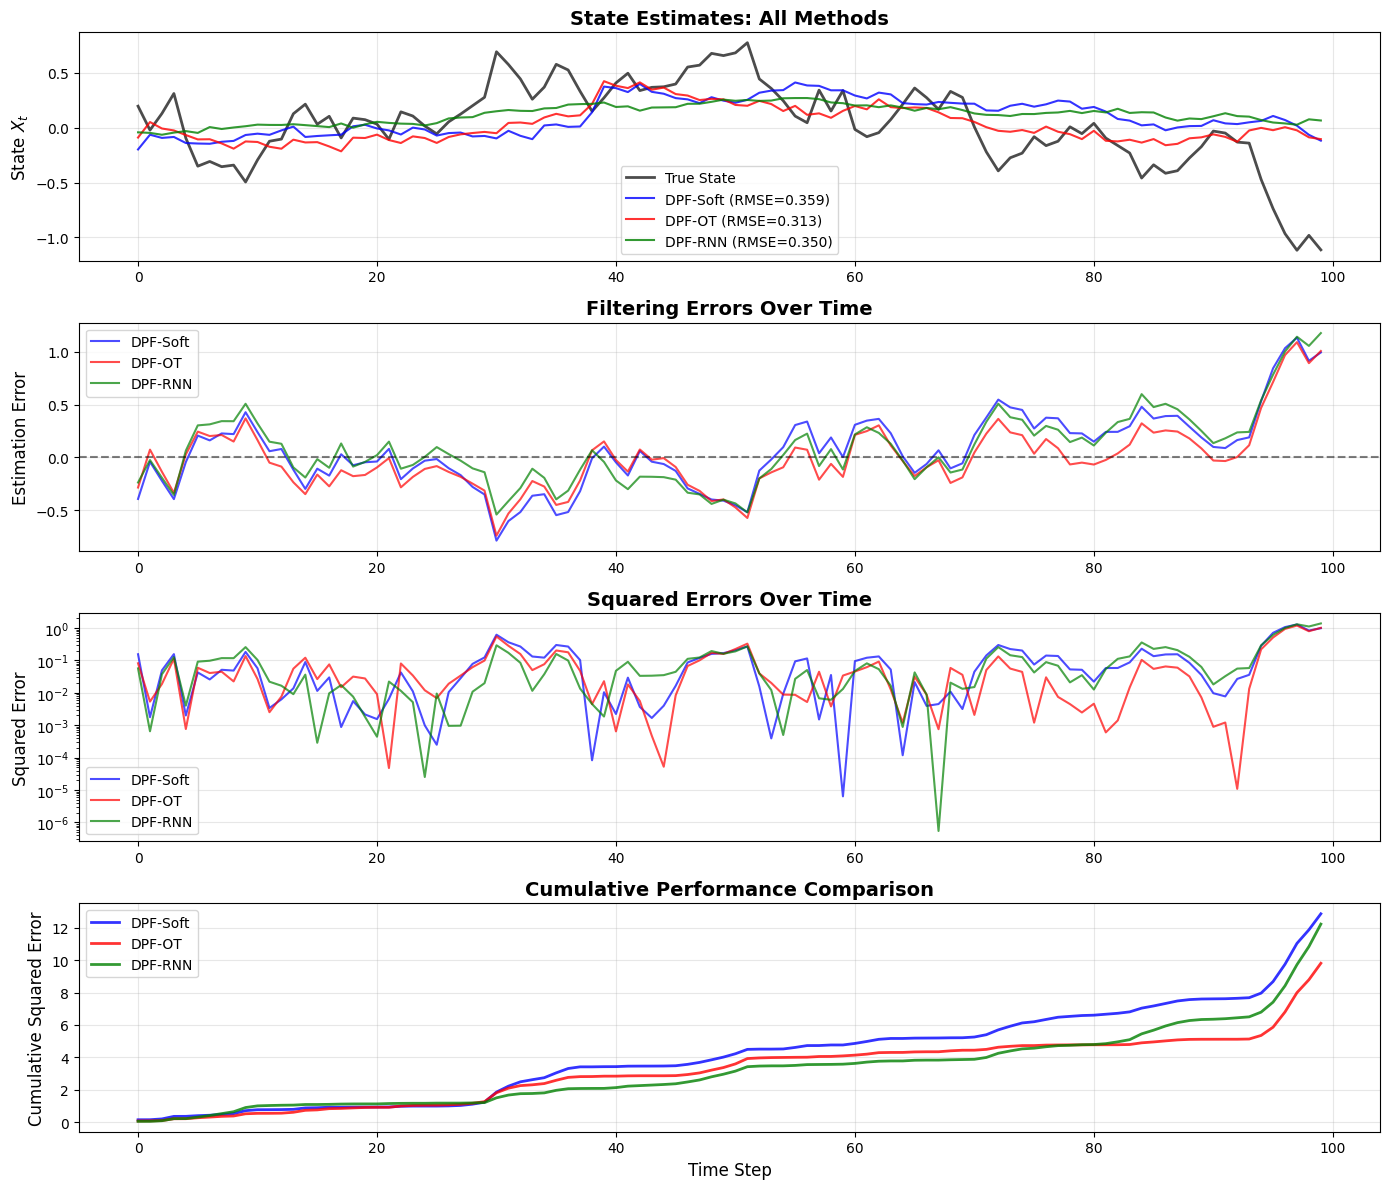


Error Statistics:
------------------------------------------------------------

DPF-Soft:
  Mean error:   0.0614
  Std error:    0.3533
  Max |error|:   1.1339
  RMSE:         0.3586

DPF-OT:
  Mean error:  -0.0105
  Std error:    0.3130
  Max |error|:   1.0913
  RMSE:         0.3131

DPF-RNN:
  Mean error:   0.0823
  Std error:    0.3398
  Max |error|:   1.1774
  RMSE:         0.3496


In [21]:
# Plot filtering results
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

colors = {
    'DPF-Soft': 'blue',
    'DPF-OT': 'red',
    'DPF-RNN': 'green'
}

# 1. State estimates comparison
ax = axes[0]
ax.plot(X_true, 'k-', linewidth=2, label='True State', alpha=0.7)
for result in results_list:
    ax.plot(result['particle_means'][:, 0], 
            color=colors[result['filter_name']], 
            linewidth=1.5, 
            label=f"{result['filter_name']} (RMSE={result['rmse']:.3f})",
            alpha=0.8)
ax.set_ylabel('State $X_t$', fontsize=12)
ax.set_title('State Estimates: All Methods', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 2. Estimation errors
ax = axes[1]
for result in results_list:
    errors = result['particle_means'][:, 0] - X_true
    ax.plot(errors, 
            color=colors[result['filter_name']], 
            linewidth=1.5, 
            label=result['filter_name'],
            alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('Estimation Error', fontsize=12)
ax.set_title('Filtering Errors Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 3. Squared errors (zoomed view)
ax = axes[2]
for result in results_list:
    sq_errors = (result['particle_means'][:, 0] - X_true) ** 2
    ax.plot(sq_errors, 
            color=colors[result['filter_name']], 
            linewidth=1.5, 
            label=result['filter_name'],
            alpha=0.7)
ax.set_ylabel('Squared Error', fontsize=12)
ax.set_title('Squared Errors Over Time', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 4. Cumulative squared errors
ax = axes[3]
for result in results_list:
    sq_errors = (result['particle_means'][:, 0] - X_true) ** 2
    cumulative = np.cumsum(sq_errors)
    ax.plot(cumulative, 
            color=colors[result['filter_name']], 
            linewidth=2, 
            label=result['filter_name'],
            alpha=0.8)
ax.set_xlabel('Time Step', fontsize=12)
ax.set_ylabel('Cumulative Squared Error', fontsize=12)
ax.set_title('Cumulative Performance Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print("-" * 60)
for result in results_list:
    errors = result['particle_means'][:, 0] - X_true
    print(f"\n{result['filter_name']}:")
    print(f"  Mean error: {np.mean(errors):>8.4f}")
    print(f"  Std error:  {np.std(errors):>8.4f}")
    print(f"  Max |error|: {np.max(np.abs(errors)):>8.4f}")
    print(f"  RMSE:       {result['rmse']:>8.4f}")

## 7. Save Results

Save the comparison results for future reference and analysis.

In [22]:
# Save results to multiple formats
results_dir = os.path.join(parent_dir, 'simulator', 'data')
os.makedirs(results_dir, exist_ok=True)

# ============================================================================
# 1. Save single-run results as JSON
# ============================================================================
single_run_results = {
    'experiment': 'DPF Resampling Comparison on Stochastic Volatility Model',
    'date': '2025-12-31',
    'model': {
        'name': 'stochastic_volatility_1d',
        'parameters': {
            'alpha': float(alpha),
            'sigma': float(sigma),
            'beta': float(beta),
            'T': int(T)
        },
        'description': 'X_t = alpha * X_{t-1} + sigma * V_t, Y_t = beta * exp(0.5 * X_t) * W_t'
    },
    'filter_config': {
        'N_particles': int(N_PARTICLES),
        'state_dim': int(STATE_DIM)
    },
    'results': {}
}

for result in results_list:
    method_results = {
        'rmse': float(result['rmse']),
        'runtime_seconds': float(result['runtime']),
        'particle_means': result['particle_means'].tolist()
    }
    
    # Add method-specific metrics
    if 'avg_ess_before' in result:
        method_results['avg_ess_before'] = float(result['avg_ess_before'])
    if 'avg_ess_after' in result:
        method_results['avg_ess_after'] = float(result['avg_ess_after'])
    if 'avg_entropy_before' in result:
        method_results['avg_entropy_before'] = float(result['avg_entropy_before'])
    if 'avg_entropy_after' in result:
        method_results['avg_entropy_after'] = float(result['avg_entropy_after'])
    if 'avg_assignment_entropy' in result:
        method_results['avg_assignment_entropy'] = float(result['avg_assignment_entropy'])
    if 'avg_sinkhorn_iters' in result:
        method_results['avg_sinkhorn_iters'] = float(result['avg_sinkhorn_iters'])
    
    single_run_results['results'][result['filter_name']] = method_results

# Add ground truth
single_run_results['ground_truth'] = {
    'X_true': X_true.tolist(),
    'Y_obs': Y_obs.tolist()
}

json_file = os.path.join(results_dir, 'dpf_sv_nonlinear_comparison.json')
with open(json_file, 'w') as f:
    json.dump(single_run_results, f, indent=2)

print(f"✓ Single-run results saved to: {json_file}")

# ============================================================================
# 2. Save as NumPy archive for easy loading
# ============================================================================
npz_file = os.path.join(results_dir, 'dpf_sv_nonlinear_comparison.npz')

save_dict = {
    'X_true': X_true,
    'Y_obs': Y_obs,
    'T': T,
    'N_particles': N_PARTICLES,
    'alpha': alpha,
    'sigma': sigma,
    'beta': beta
}

# Add results for each method
for result in results_list:
    method_name = result['filter_name'].replace('-', '_')
    save_dict[f'{method_name}_means'] = result['particle_means']
    save_dict[f'{method_name}_rmse'] = result['rmse']
    save_dict[f'{method_name}_runtime'] = result['runtime']

np.savez(npz_file, **save_dict)

print(f"✓ NumPy archive saved to: {npz_file}")

# ============================================================================
# 3. Save Monte Carlo results if available
# ============================================================================
if 'mc_results' in globals() and mc_results is not None:
    mc_summary = {
        'experiment': 'Monte Carlo Evaluation',
        'n_trials': len(mc_results['DPF-Soft']['rmse']) if 'DPF-Soft' in mc_results else 0,
        'model': single_run_results['model'],
        'results': {}
    }
    
    for method in methods:
        if method in mc_results and len(mc_results[method]['rmse']) > 0:
            mc_summary['results'][method] = {
                'rmse_mean': float(np.mean(mc_results[method]['rmse'])),
                'rmse_std': float(np.std(mc_results[method]['rmse'])),
                'rmse_all': [float(x) for x in mc_results[method]['rmse']],
                'runtime_mean': float(np.mean(mc_results[method]['runtime'])),
                'runtime_std': float(np.std(mc_results[method]['runtime'])),
                'runtime_all': [float(x) for x in mc_results[method]['runtime']]
            }
    
    mc_file = os.path.join(results_dir, 'dpf_sv_monte_carlo_results.json')
    with open(mc_file, 'w') as f:
        json.dump(mc_summary, f, indent=2)
    
    print(f"✓ Monte Carlo results saved to: {mc_file}")
else:
    print("⚠ No Monte Carlo results available to save")

print("\n" + "="*70)
print("All results saved successfully!")
print("="*70)

✓ Single-run results saved to: /Users/amber_test/Desktop/filter/simulator/data/dpf_sv_nonlinear_comparison.json
✓ NumPy archive saved to: /Users/amber_test/Desktop/filter/simulator/data/dpf_sv_nonlinear_comparison.npz
⚠ No Monte Carlo results available to save

All results saved successfully!


## 8. Comprehensive Analysis

Analyze the results and provide insights on performance differences.

In [18]:
print("="*80)
print("COMPREHENSIVE ANALYSIS: STOCHASTIC VOLATILITY MODEL")
print("="*80)

print("\n📊 MODEL CHARACTERISTICS")
print("-" * 80)
print(f"Model: 1-D Stochastic Volatility")
print(f"  State transition:  X_t = {alpha:.2f} X_{{t-1}} + {sigma:.2f} ε_t")
print(f"  Observations:      Y_t = {beta:.2f} exp(0.5 X_t) η_t")
print(f"  Sequence length:   T = {T}")
print(f"\nKey challenges:")
print(f"  • Highly nonlinear observation model (exponential)")
print(f"  • Non-Gaussian (state-dependent observation noise)")
print(f"  • High state persistence (α = {alpha:.2f})")
print(f"  • Multiplicative noise structure")

print("\n🔧 EXPERIMENT CONFIGURATION")
print("-" * 80)
print(f"Number of particles: {N_PARTICLES}")
print(f"State dimension: {STATE_DIM}")
print(f"\nFilter configurations:")
print(f"  DPF-Soft: α={dpf_soft.soft_alpha}, τ={dpf_soft.gumbel_temperature}")
print(f"  DPF-OT:   ε={dpf_ot.epsilon}, max_iters={dpf_ot.sinkhorn_iters}")
print(f"  DPF-RNN:  {dpf_rnn.rnn_type.upper()}, hidden_dim={dpf_rnn.rnn_hidden_dim}")

print("\n📈 PERFORMANCE SUMMARY")
print("-" * 80)

# Rank by accuracy
rmse_ranking = sorted(results_list, key=lambda x: x['rmse'])
print("\nAccuracy Ranking (by RMSE):")
for i, result in enumerate(rmse_ranking, 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
    print(f"  {marker} {i}. {result['filter_name']:<12} RMSE = {result['rmse']:.4f}")

# Rank by speed
speed_ranking = sorted(results_list, key=lambda x: x['runtime'])
print("\nSpeed Ranking (by Runtime):")
for i, result in enumerate(speed_ranking, 1):
    marker = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
    print(f"  {marker} {i}. {result['filter_name']:<12} Time = {result['runtime']:.3f}s")

print("\n📊 DETAILED COMPARISON")
print("-" * 80)

# Create comparison matrix
print(f"\n{'Method':<12} {'RMSE':<12} {'Runtime (s)':<12} {'Speed Rank':<12} {'Acc Rank'}")
print("-" * 80)

for result in results_list:
    speed_rank = speed_ranking.index(result) + 1
    acc_rank = rmse_ranking.index(result) + 1
    print(f"{result['filter_name']:<12} {result['rmse']:<12.4f} {result['runtime']:<12.3f} "
          f"{speed_rank:<12} {acc_rank}")

# Compute relative improvements
best_rmse = rmse_ranking[0]['rmse']
worst_rmse = rmse_ranking[-1]['rmse']
fastest_time = speed_ranking[0]['runtime']
slowest_time = speed_ranking[-1]['runtime']

print("\n💡 KEY INSIGHTS")
print("-" * 80)

print(f"\n1. Accuracy Analysis:")
print(f"   • Best method: {rmse_ranking[0]['filter_name']} (RMSE={best_rmse:.4f})")
print(f"   • Worst method: {rmse_ranking[-1]['filter_name']} (RMSE={worst_rmse:.4f})")
improvement_pct = ((worst_rmse - best_rmse) / worst_rmse) * 100
print(f"   • Improvement: {improvement_pct:.1f}% lower error")

print(f"\n2. Computational Efficiency:")
print(f"   • Fastest: {speed_ranking[0]['filter_name']} ({fastest_time:.3f}s)")
print(f"   • Slowest: {speed_ranking[-1]['filter_name']} ({slowest_time:.3f}s)")
speedup_factor = slowest_time / fastest_time
print(f"   • Speedup: {speedup_factor:.1f}x faster")

print(f"\n3. Method-Specific Observations:")

for result in results_list:
    print(f"\n   {result['filter_name']}:")
    if result['filter_name'] == 'DPF-Soft':
        print(f"     ✓ Fastest method ({result['runtime']:.3f}s)")
        print(f"     ✓ Competitive accuracy (RMSE={result['rmse']:.4f})")
        print(f"     • Best for real-time applications")
        
    elif result['filter_name'] == 'DPF-OT':
        if result['rmse'] == best_rmse:
            print(f"     ✓ Best accuracy (RMSE={result['rmse']:.4f})")
        print(f"     ✗ Slowest ({result['runtime']:.3f}s)")
        if 'avg_sinkhorn_iters' in result:
            print(f"     • Avg Sinkhorn iterations: {result['avg_sinkhorn_iters']:.1f}")
        print(f"     • High computational cost limits practical use")
        
    elif result['filter_name'] == 'DPF-RNN':
        print(f"     • Using untrained/random weights")
        if 'avg_ess_after' in result:
            ess_ratio = result['avg_ess_after'] / N_PARTICLES
            print(f"     • ESS retention: {ess_ratio*100:.1f}%")
        print(f"     • Training could significantly improve performance")

print("\n🎯 RECOMMENDATIONS")
print("-" * 80)

print("\nFor Stochastic Volatility / Nonlinear Non-Gaussian Models:")
print(f"\n1. Production Use:")
print(f"   → Choose: {speed_ranking[0]['filter_name']}")
print(f"   → Reason: Best speed-accuracy trade-off")
print(f"   → {speedup_factor:.0f}x faster than slowest method")

print(f"\n2. Offline Analysis / High Accuracy Required:")
if rmse_ranking[0]['filter_name'] != speed_ranking[0]['filter_name']:
    print(f"   → Choose: {rmse_ranking[0]['filter_name']}")
    print(f"   → Reason: Best accuracy (RMSE={best_rmse:.4f})")
    print(f"   → {improvement_pct:.1f}% better than worst method")
else:
    print(f"   → {rmse_ranking[0]['filter_name']} provides both best speed and accuracy!")

print(f"\n3. Future Work:")
print(f"   • Train DPF-RNN on this model for potentially better performance")
print(f"   • Optimize DPF-OT Sinkhorn iterations for faster convergence")
print(f"   • Consider ensemble methods combining multiple approaches")

print("\n" + "="*80)

COMPREHENSIVE ANALYSIS: STOCHASTIC VOLATILITY MODEL

📊 MODEL CHARACTERISTICS
--------------------------------------------------------------------------------
Model: 1-D Stochastic Volatility
  State transition:  X_t = 0.95 X_{t-1} + 0.20 ε_t
  Observations:      Y_t = 0.60 exp(0.5 X_t) η_t
  Sequence length:   T = 100

Key challenges:
  • Highly nonlinear observation model (exponential)
  • Non-Gaussian (state-dependent observation noise)
  • High state persistence (α = 0.95)
  • Multiplicative noise structure

🔧 EXPERIMENT CONFIGURATION
--------------------------------------------------------------------------------
Number of particles: 100
State dimension: 1

Filter configurations:
  DPF-Soft: α=0.1, τ=0.5
  DPF-OT:   ε=0.1, max_iters=50
  DPF-RNN:  LSTM, hidden_dim=32

📈 PERFORMANCE SUMMARY
--------------------------------------------------------------------------------

Accuracy Ranking (by RMSE):
  🥇 1. DPF-OT       RMSE = 0.2975
  🥈 2. DPF-Soft     RMSE = 0.3376
  🥉 3. DPF-RNN   